# Семинар 3: Классификация изображений

## Вступление
Сегодня мы перейдём чуть более сложным данным и архитектурам для классификации изображений.

### План семинара
1. Обучаем свёрточную сеть для задачи классификации изображений и смотрим на полученные фильтры свёрточных слоёв
2. Разбираемся с тем, что такое аугментации и зачем они нужны
3. Узнаём про способы регуляризации и нормализации при обучении нейронных сетей


In [58]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Обучаем свёрточную сеть для задачи классификации изображений

Сегодня будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000. Загрузим его аналогично тому, как мы загружали MNIST на предыдущих занятиях.

In [60]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
# Тут батч по 50000 надо делать
# for x,y in train_dataloader:
#     print(torch.sum(x[:,0,:,:])/(50000*32*32))
    
# for x,y in train_dataloader:
#     print(torch.sum(x[:,1,:,:])/(50000*32*32))

# for x,y in train_dataloader:
#     print(torch.sum(x[:,2,:,:])/(50000*32*32))
    
# for x,y in train_dataloader:
#     print(torch.sqrt(torch.sum(x[:,0,:,:]**2)/(50000*32*32)-0.4914**2))    

In [75]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

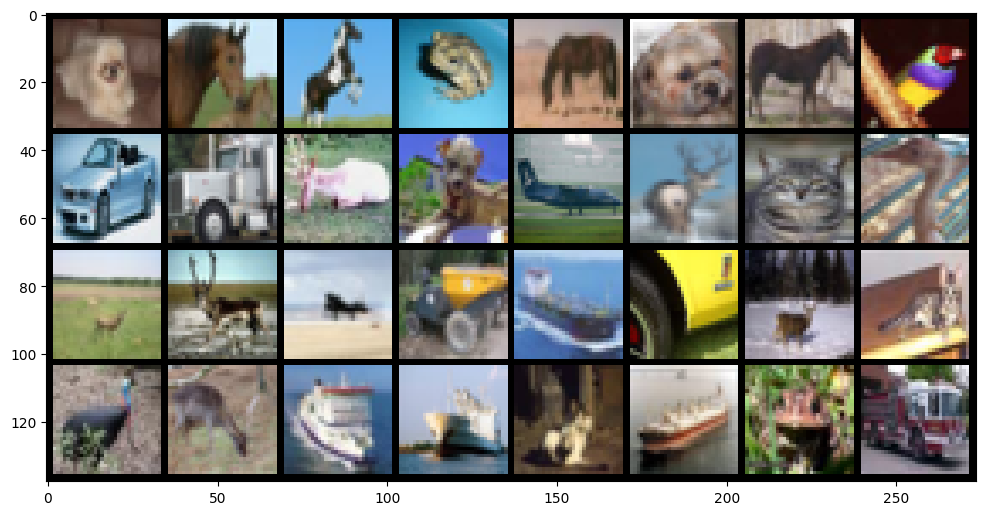

In [63]:
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
img_grid.size()
# plt.imshow(img_grid.permute(1,2,0))
matplotlib_imshow(img_grid)

In [64]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [65]:
a = torch.tensor([[1,2,3,4],
                  [1,2,3,4],
                  [1,2,3,4],
                  [1,2,3,4],])
a.unsqueeze_(0).unsqueeze_(0)
nn.functional.max_pool2d(a,2,2)

tensor([[[[2, 4],
          [2, 4]]]])

### Задание 1. VGG
В качестве бейзлайна постройте следующую архитектуру из 1 VGG блока:

1) VGG блок с 16 каналами:
* свёрточный слой с 16 выходными каналами и ядром 3x3, паддингом и нелинейностью ReLU
* свёрточный слой с 16 выходными каналами и ядром 3x3, паддингом и нелинейностью ReLU
* Max pooling c ядром 2x2 и шагом 2

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами

In [67]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )
        
        self.fc_1 = nn.Linear(16*16*16, 128)
        self.fc_2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        pred = self.vgg(x)
        pred = self.flat(pred)
        pred = self.fc_2(self.relu(self.fc_1(pred)))
        return pred


In [68]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0))
            )
            train_loss_log.append(loss.cpu().data)

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                train_epoch_true_hits.sum()
                / train_epoch_true_hits.size(0)
                / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                val_epoch_true_hits.sum()
                / val_epoch_true_hits.size(0)
                / val_dataloader.batch_size
            ).item(),
        )

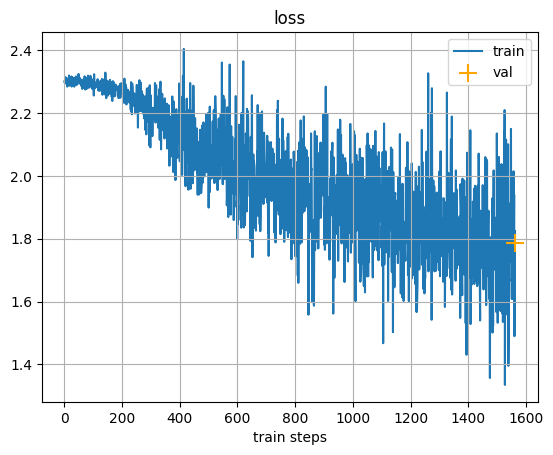

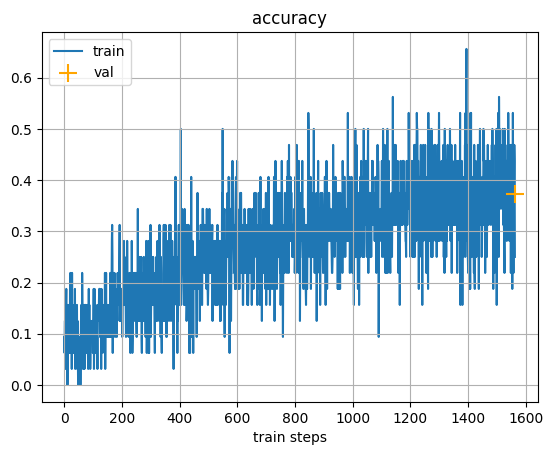

Train loss: 2.0004310607910156
Train acc: 0.27351248264312744
Val loss: 1.7855709791183472
Val acc: 0.37290334701538086


In [39]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

### Визуализируем параметры сети

In [36]:
# Запустите эти ячейки при работе из колаба
# !wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem03/filter_viz.py

# import sys
# from google.colab import drive

# drive.mount("/content/gdrive")
# sys.path.append("/content/gdrive/My Drive")

In [35]:
import httpimport
with httpimport.remote_repo('https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem03/'):
    import filter_viz


In [ ]:
model_baseline.cpu()


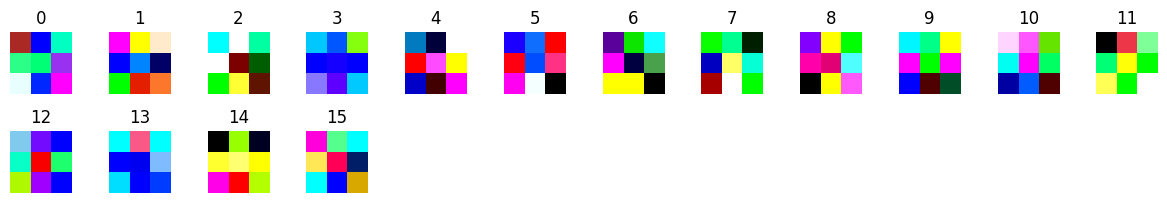

In [43]:
filter_viz.plot_filters(model_baseline.vgg[0], single_channel=False)

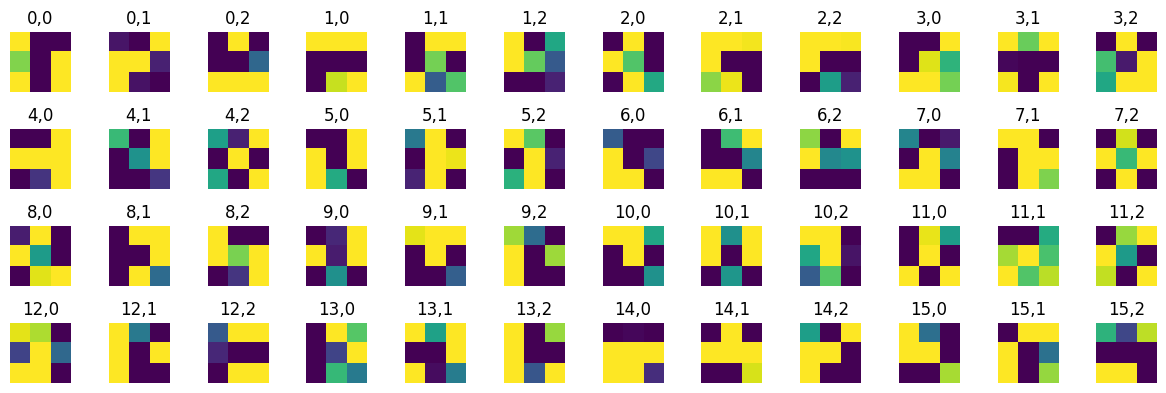

In [50]:
filter_viz.plot_filters(model_baseline.vgg[0], single_channel=True) 

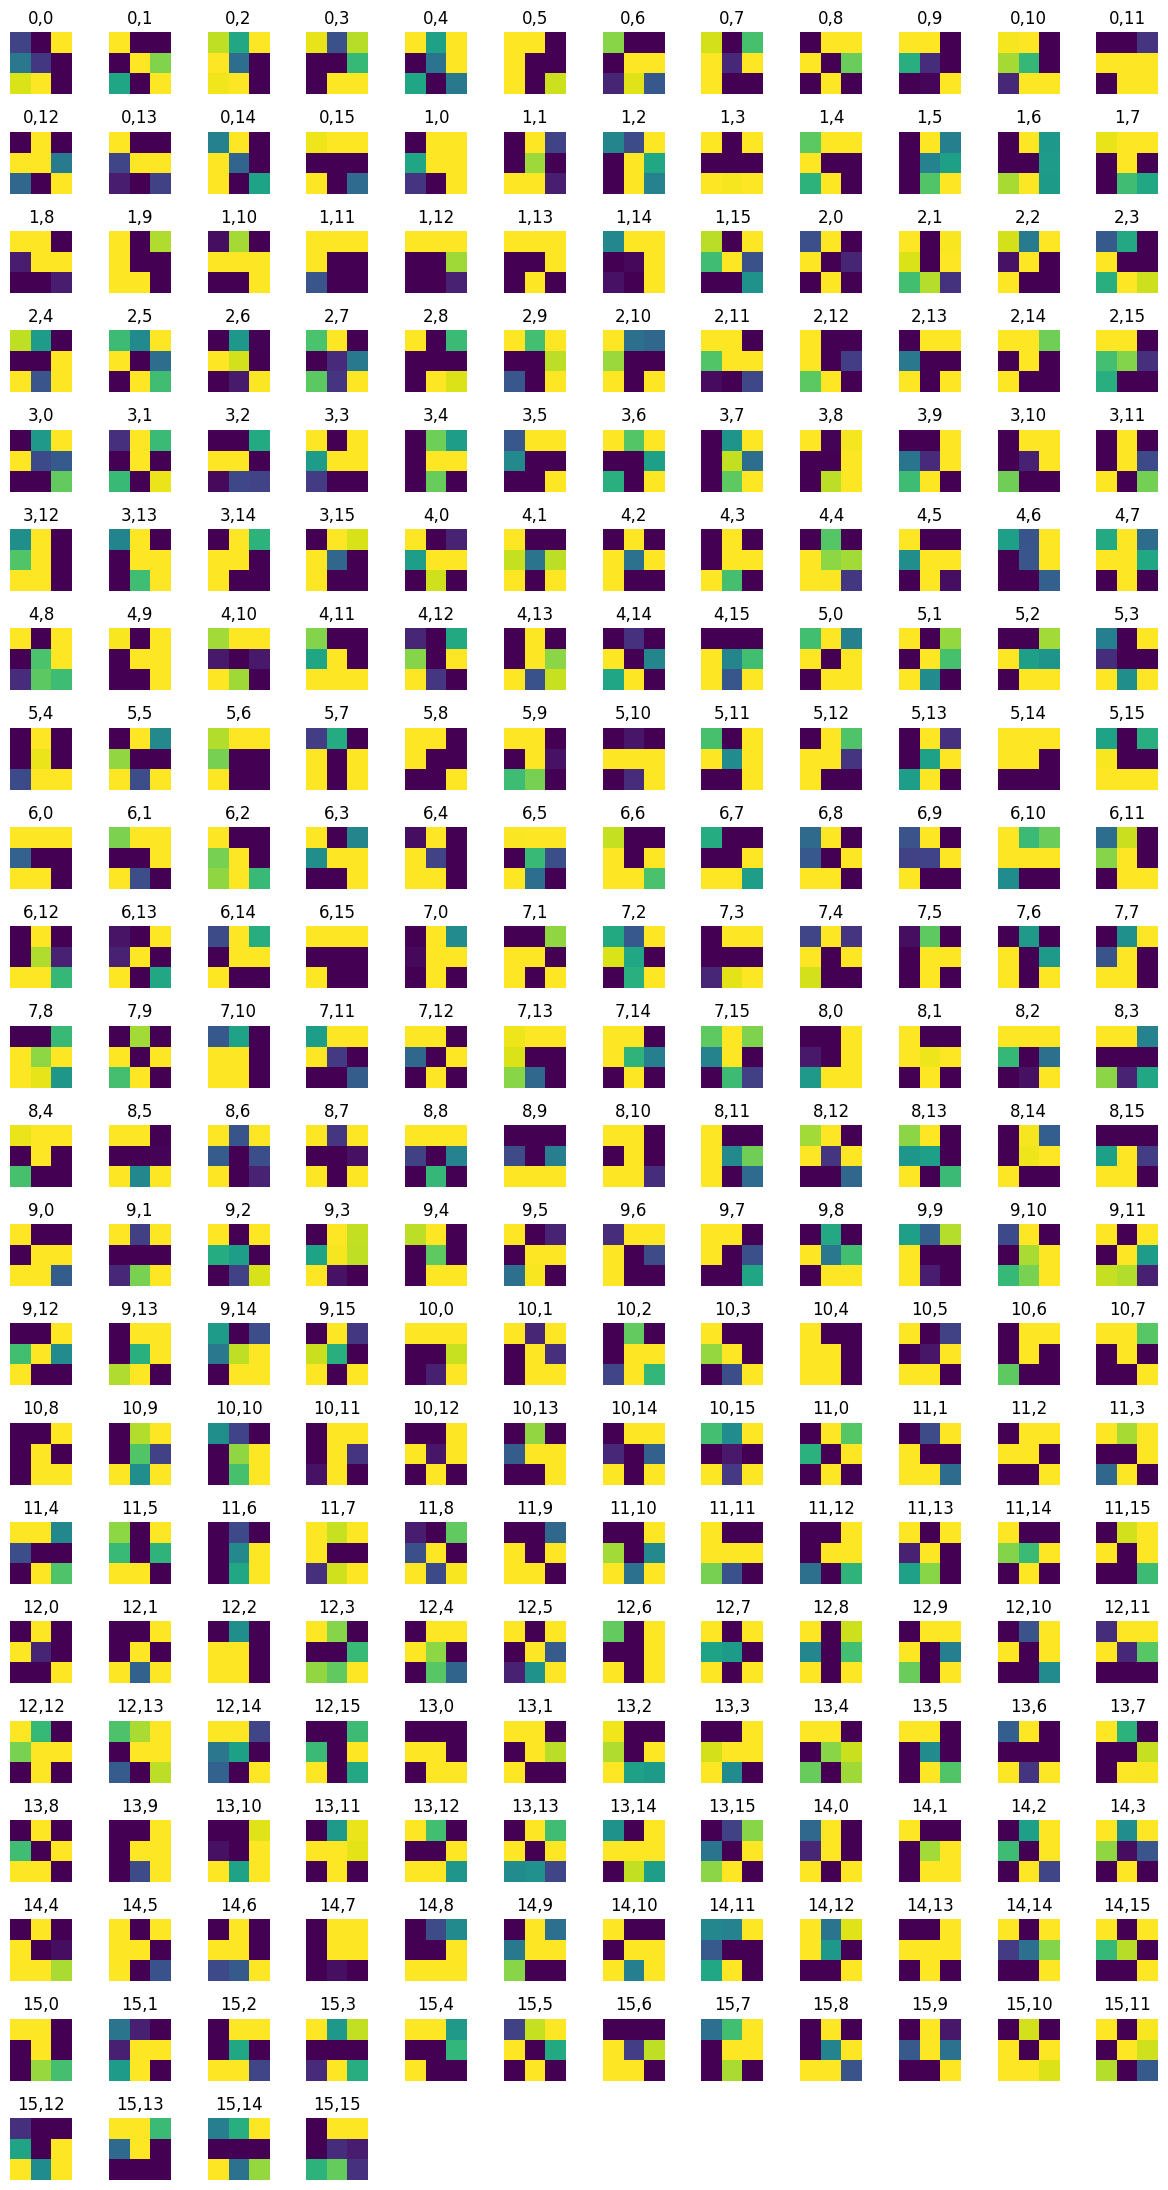

In [54]:
filter_viz.plot_filters(model_baseline.vgg[2], single_channel=True)

In [51]:
model_baseline.vgg[0].weight.data.shape

torch.Size([16, 3, 3, 3])

### Задание 2. Активации

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

Почитать про разные функции активации можно [здесь](https://ml-explained.com/blog/activation-functions-explained) и в [документации PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

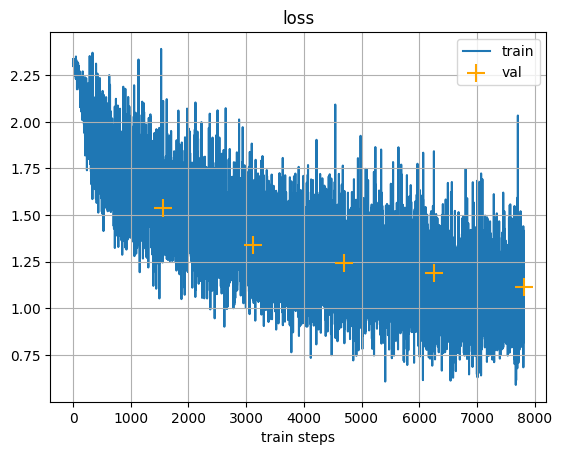

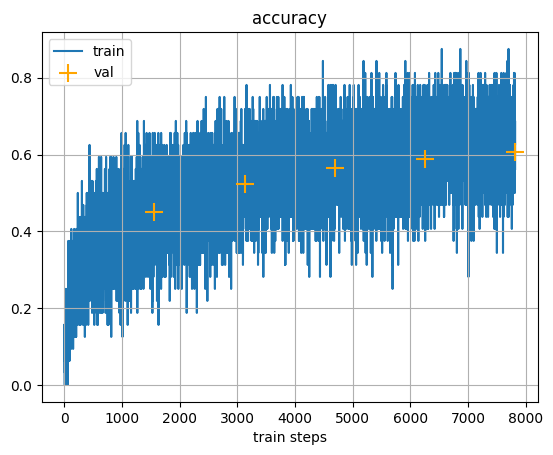

Train loss: 1.0792049169540405
Train acc: 0.6224208474159241
Val loss: 1.1171823740005493
Val acc: 0.6078274846076965


In [70]:
class ModelBaseline(nn.Module):
    def __init__(self, activation = nn.ReLU):
       super().__init__()
       self.vgg = nn.Sequential(
           nn.Conv2d(3,16,3,padding='same'),
           activation(),
           nn.Conv2d(16,16,3,padding='same'),
           activation(),
           nn.MaxPool2d(2,stride=2)
       )
       self.act = activation()
       self.fc_1 = nn.Linear(16*16*16, 128)
       self.fc_2 = nn.Linear(128, 10)
       self.flat = nn.Flatten()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        pred = self.vgg(x)
        pred = self.flat(pred)
        pred = self.fc_2(self.act(self.fc_1(pred)))
        return pred


model_baseline2 = ModelBaseline(activation=nn.SELU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline2.parameters(), lr=0.001, momentum=0.9)
train(model_baseline2, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5)

C LeakyReLU работает немного лучше)

## 2. Аугментации

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/vision/stable/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения.

Довольно мощным и эффективным инструментом для аугментаций на картинках является библиотека `albumentations`. В этом курсе мы не будем её рассматривать, но можете поэкспериментировать с ней сами.

In [76]:
import PIL

transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=base_transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


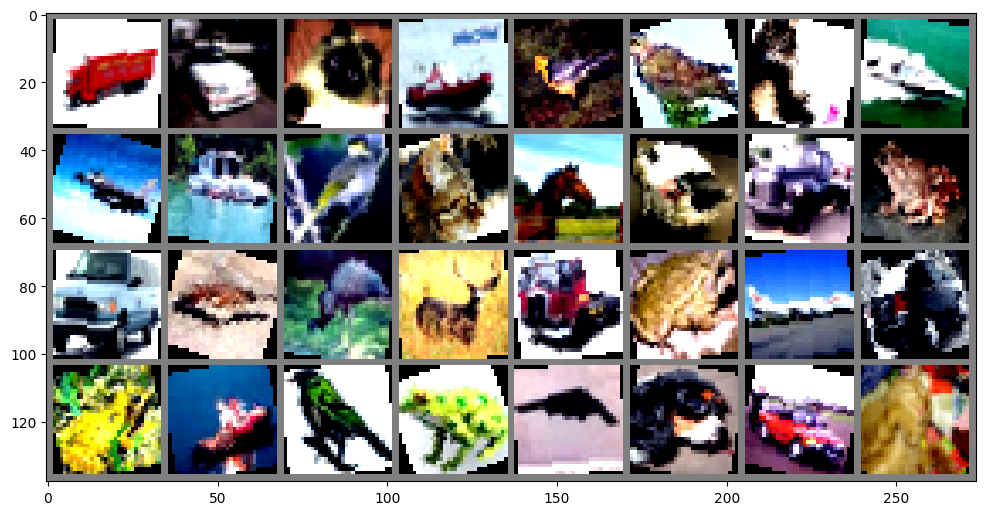

In [77]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

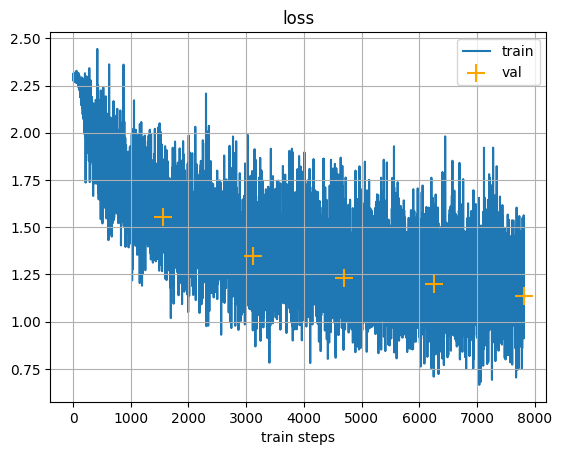

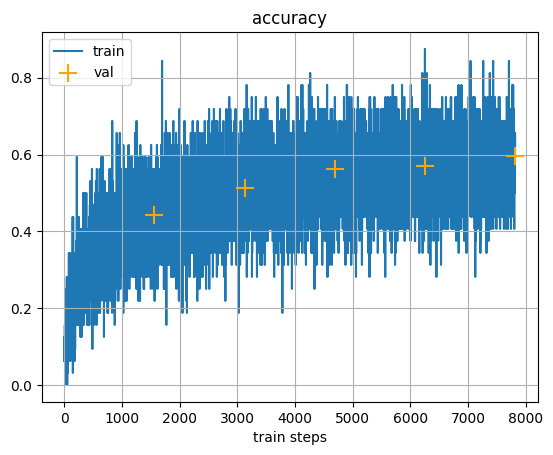

Train loss: 1.2008330821990967
Train acc: 0.5712971687316895
Val loss: 1.1364887952804565
Val acc: 0.597244381904602


In [78]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

## 3. Регуляризации и нормализации в нейронных сетях

### Dropout
Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим можно использовать Dropout. Идея метода очень проста. На тренировке `torch.nn.Dropout` зануляет каждый элемент входного тензора с вероятностью $p$. На инференсе ничего не зануляется, но, для того, чтобы сохранить масштаб выходов сети, все элементы входного тензора делятся на $1 - p$.

![Dropout](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem03/static/dropout.png?raw=1)

Для стабилизации и ускорения сходимости обучения часто используют батч нормализацию. В **PyTorch** она тоже имплементирована в виде слоя — [`torch.nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Обычно батч нормализацию вставляют между смысловыми блоками нейронной сети, чтобы сохранять распределение данных на всём forward pass. Обратите внимание, что на тренировке выборочные среднее и стандартное отклонение каждый раз заново вычисляются по батчу, а также у слоя есть обучаемых два числовых параметра на каждый канал входного тензора. На инференсе в качестве среднего и дисперсии используются оценки, полученные скользящими средними во время тренировки.

![Batch Norm](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem03/static/batch_norm.png?raw=1)

Давайте обучим новую сеть, в которой будет 3 VGG блока и добавим в неё батч нормализацию и дропаут.

In [137]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
)

In [138]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

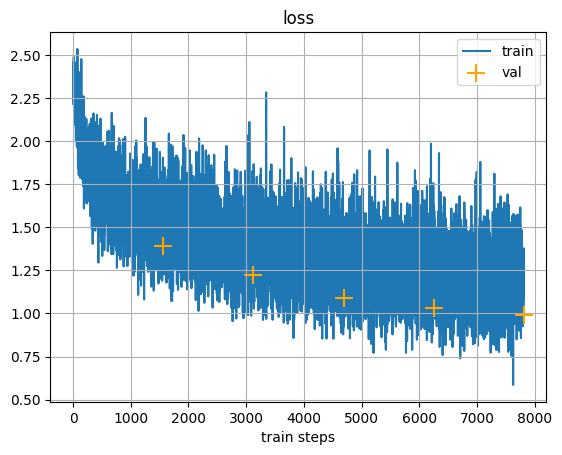

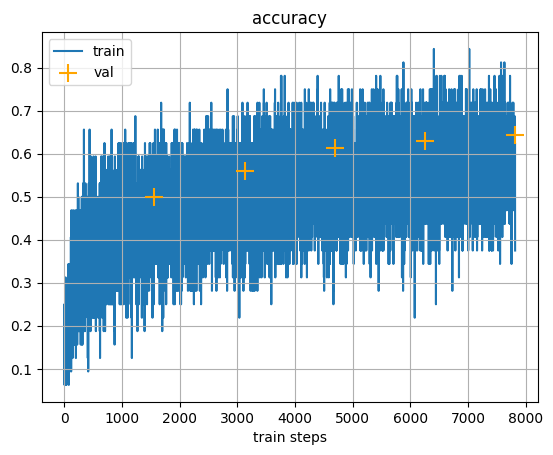

Train loss: 1.2048407793045044
Train acc: 0.5706773996353149
Val loss: 0.9902219176292419
Val acc: 0.6427715420722961


In [139]:
train(model, criterion, optimizer, train_dataloader, val_dataloader)